In [140]:
#-*- coding:utf8-*-
%matplotlib inline

#from __future__ import absolute_import, division, print_function, unicode_literals

from IPython.display import Image, display

from fractions import Fraction

import numpy as np

import uncertainties as unc
from uncertainties import unumpy as unp
from uncertainties.unumpy import std_devs as stds #TODO
from uncertainties.unumpy import nominal_values as noms #TODO

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D 

import seaborn as sns
sns.set(context="paper",font_scale=1.4)

import scipy as sp
import scipy.constants as const

import sympy as sym

import pandas as pd

#import ROOT as rt

#import root_numpy as rnp

from aputils.latextables.tables import Table


# Fehlerfortpflanzung beim Mitteln
umean = unc.wrap(np.mean)

#Laden des Latex fonts 
if "lmodern" not in plt.rcParams["text.latex.preamble"]:
    plt.rcParams['text.latex.preamble']=["\\usepackage{lmodern}"]

if "siunitx" not in plt.rcParams["text.latex.preamble"]:
    plt.rcParams["text.latex.preamble"].append(r"\usepackage{siunitx}")


params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'axes.labelsize':11,
          'legend.fontsize':11,
          'figure.figsize': (5.906, 3.937),
          #'savefig.dpi'         : 200
         }
plt.rcParams.update(params) 

# figsize of 13cm * 8cm (values have to be given in inch)
#figure.figsize      : 5,11811, 3,14961
#savefig.dpi         : 300

#Größe der Achsenbeschriftung
#axis_font = {'size':'14'}

# Pfade
path_graphics = "../Grafiken/"
graphic = lambda path: "../Grafiken/" + path
path_table = "../Tabellen/"
path_data = "../Messdaten/"

/home/luckyjosh/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [141]:
# Funktionen
# Achsenbeschriftungen
def axis_label(label,sym=None,unit=None):
    if sym == None:
        return lable
    elif unit == None:
        return r"".join([label," ${s}$".format(s=sym)])
    else:
        return r"".join([label," ${s}/\mathrm{{{u}}}$".format(s=sym,u=unit)])

# Achsenskalierung
def axis_scale(factor, axis="x"):
    if axis == "x":
        plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: x * factor))
    elif axis == "y":
        plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: x * factor))
    else:
        print("Wrong axis name given! Only x and y are allowed!")
    

def siunitx_ticklabels(ax=None, locale="DE", xaxis=True, yaxis=True,
                       round_precision=2, round_mode="places", scale_x=None, scale_y=None):
    """
    This function uses siunitx to create the ticklabels
    Main reason is for adjusting the decimal marker properly.
    The function takes 4 arguments:
        ax=None     the matplotlib axes to operate on
                    if set to None (Standard) this will be the current axes
        locale="DE" The locale parameter for siunitx, one of
                    "UK", "US", "DE", "FR" oder "ZA"
        xaxis=True  Boolean, if True the labels for the xaxis are set
        yaxis=True  Boolean, if True the labels for the yaxis are set
        round_precision=2 Number of places or figures after rounding
        round_mode="places" Rounds to round_precision many decimal places,
                  "figures" Rounds to round_precision many significant figures
                  
    """

    if ax is None:
        ax = plt.gca()

    if scale_x == None:
        scale_x = 1
    if scale_y == None:
        scale_y = 1
    
    if isinstance(round_precision, tuple):
        precision_x = round_precision[0]
        precision_y = round_precision[1]
    elif isinstance(round_precision,int):
        precision_x = round_precision
        precision_y = round_precision
    else:
        print("{type} is no supported type for 'round_precision', only 'int' and 'tuple' are!")
        
    
    if xaxis is True:
        xticks = ax.get_xticks()
        #print(xticks)
        xlabels = [r"$\num[locale={},round-mode={},round-precision={}]{{{}}}$".format(
                   locale, round_mode,precision_x, tick*scale_x) for tick in xticks]
        #print(xlabels)
        ax.set_xticklabels(xlabels)

    if yaxis is True:
        yticks = ax.get_yticks()
        ylabels = [r"$\num[locale={},round-mode={},round-precision={}]{{{}}}$".format(
                   locale, round_mode,precision_y, tick*scale_y) for tick in yticks]
        #print(ylabels)
        ax.set_yticklabels(ylabels)    
        
def create_pi_labels(a=0, b=2, step=0.5, ax=None, direction='x'):
    """
    A function that gives back ticks an labels in radians
    Keyword arguments:
    a -- lower limit is a*pi (default 0.0)
    b -- upper limit is b*pi (default 2.0)
    step -- step is step*pi  (default 0.5)
    ax -- if ax is not None then ticks and labels are set for this axes (default None)
    direction -- 'x' or 'y' or 'z' (default 'x') which axis you want to label
    return value is ticks, labels
    """

    max_denominator = int(1/step)
    values = np.arange(a, b+0.1*step, step)
    fracs = [Fraction(x).limit_denominator(max_denominator) for x in values]
    ticks = values*np.pi

    if plt.rcParams["text.usetex"] is True:
        vspace = r"\vphantom{\frac{1}{2}}"
    else:
        vspace = ""

    labels = []

    for frac in fracs:
        if frac.numerator==0:
            labels.append(r"$0" + vspace + "$")
        elif frac.numerator<0:
            if frac.denominator==1 and abs(frac.numerator)==1:
                labels.append(r"$-\pi" + vspace + "$")
            elif frac.denominator==1:
                labels.append(r"$-{}\pi".format(abs(frac.numerator)) +vspace + "$")
            else:
                labels.append(r"$-\frac{{{}}}{{{}}} \pi$".format(abs(frac.numerator), frac.denominator))
        else:
            if frac.denominator==1 and frac.numerator==1:
                labels.append(r"$\pi" + vspace + "$")
            elif frac.denominator==1:
                labels.append(r"${}\pi".format(frac.numerator) + vspace + "$")
            else:
                labels.append(r"$\frac{{{}}}{{{}}} \pi$".format(frac.numerator, frac.denominator))

    if ax is not None:
        if direction == 'x':
            ax.set_xticks(ticks)
            ax.set_xticklabels(labels)
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
        elif direction == 'y':
            ax.set_yticks(ticks)
            ax.set_yticklabels(labels)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
        elif direction == 'z':
            ax.set_zticks(ticks)
            ax.set_zticklabels(labels)
        else:
            print("direction ", direction, "is not a proper argument")

    return ticks, labels
    
    
# Fit Funktionen
def fit_errors(popt,pcov):
    errors = np.sqrt(np.diag(pcov))
    param_err = unp.uarray(popt,errors)
    return param_err
    
def print_errors(array,description=None):
    if description and len(description)==len(array):
        maxlen = max(map(len,description))
        lens = map(len,description)
        for i,entry in enumerate(array):
            print(description[i]," "*(maxlen-lens[i]),entry.nominal_value,"+/-",entry.std_dev)
    else:
        for i,entry in enumerate(array):
            print(entry.nominal_value,"+/-",entry.std_dev)
            


## Messung a) 
### Amplitudenmoduliert mit Trägerunterdrückung

In [142]:
df_amp_mod_without_carrier = pd.read_csv(path_data+"Messung_a.csv",skiprows=(0,1),names=("Zeit/s","Spannung/V"))
df_amp_mod_without_carrier.fillna(0,inplace=True)

In [143]:
df_amp_mod_without_carrier.head(1)

,Zeit/s,Spannung/V
0,-0.00005,0


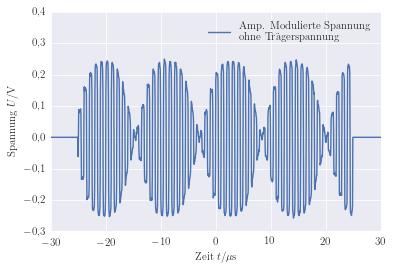

In [144]:
fig, ax = plt.subplots()

ax.set_xlim(-3e-05,3e-05)
ax.set_ylim(-0.3,0.4)
ax.set_xlabel(axis_label("Zeit",sym="t",unit="\mu s"))
ax.set_ylabel(axis_label("Spannung",sym="U",unit="V"))
siunitx_ticklabels(ax=ax,scale_x=1e06,round_precision=(0,1))

ax.plot(df_amp_mod_without_carrier["Zeit/s"],df_amp_mod_without_carrier["Spannung/V"],label="Amp. Modulierte Spannung\n ohne Trägerspannung")
ax.legend(loc="upper right")


In [145]:
fig.tight_layout()
fig.savefig(path_graphics+"Amplituden_Modulierte_Spannung_ohne_Traeger.pdf")

## Messung c) 
### Amplitudenmoduliert mit Trägerabstrahlung

In [146]:
df_amp_mod_with_carrier = pd.read_csv(path_data+"Messung_c.csv",skiprows=(0,1),names=("Zeit/s","Spannung/V"))
df_amp_mod_with_carrier.fillna(0,inplace=True)

In [147]:
df_amp_mod_with_carrier.head(1)

,Zeit/s,Spannung/V
0,-0.000022,0


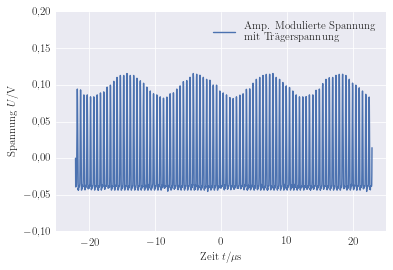

In [148]:
fig, ax = plt.subplots()

ax.set_xlim(-2.5e-05,2.5e-05)
ax.set_ylim(-0.1,0.20)
#axis_scale(1e06,axis="x") # seconds -> microseconds 
siunitx_ticklabels(ax=ax,scale_x=1e06,round_precision=(0,2))
ax.set_xlabel(axis_label("Zeit",sym="t",unit="\mu s"))
ax.set_ylabel(axis_label("Spannung",sym="U",unit="V"))
ax.plot(df_amp_mod_with_carrier["Zeit/s"],df_amp_mod_with_carrier["Spannung/V"],label="Amp. Modulierte Spannung\n mit Trägerspannung")
ax.legend(loc="upper right")
#ax.plot(max_1[0],max_1[1],marker="o")

In [149]:
fig.tight_layout()
fig.savefig(path_graphics+"Amplituden_Modulierte_Spannung_mit_Traeger.pdf")

In [150]:
# Berechnung der Maxima und Minima der Amplituden
limit_lower, limit_upper = -17.5e-06, -12.5e-06

is_in_range_x = (df_amp_mod_with_carrier["Zeit/s"] >=limit_lower)&(df_amp_mod_with_carrier["Zeit/s"] < limit_upper) 
#is_in_range_x = (df_amp_mod_with_carrier["Zeit/s"] >=limit_lower)&(df_amp_mod_with_carrier["Zeit/s"] < limit_upper) 

In [151]:
max_1 = df_amp_mod_with_carrier[is_in_range_x].max().tolist()

In [152]:
voltage_change = (np.array(df_amp_mod_with_carrier["Spannung/V"][1:]) - 
                  np.array(df_amp_mod_with_carrier["Spannung/V"][0:-1]))
voltage_change = np.insert(voltage_change,[0],0)
voltage_change

array([ 0.        , -0.03905314, -0.00016583, ...,  0.00198995,
        0.01409548,  0.03664824])

In [153]:
#df_amp_mod_with_carrier["Spannungsänderung/V"] = voltage_change

In [154]:
df_amp_mod_with_carrier.head(5)

,Zeit/s,Spannung/V
0,-0.000022,0.000000
1,-0.000022,-0.039053
2,-0.000022,-0.039219
3,-0.000022,-0.038224
4,-0.000022,-0.038224


In [155]:
voltage_change_sign = np.sign(voltage_change)

In [156]:
voltage_change_sign

array([ 0., -1., -1., ...,  1.,  1.,  1.])

In [157]:
def rolling_window(a, size):
    shape = a.shape[:-1] + (a.shape[-1] - size + 1, size)
    #print(a.shape[:-1], a.shape[-1],-size+1 ,shape)
    strides = a.strides + (a. strides[-1],)
    #print(strides,a. strides[-1])
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [158]:
# Stellen der Änderung des Vorzeichens von + nach - 
## Absuchen der Spannungsänderung in 3er Blöcken
voltage_change_rolling_window = (rolling_window(voltage_change_sign,3) == (1,1,-1))
voltage_change_rolling_window

array([[False, False,  True],
       [False, False, False],
       [False,  True, False],
       ..., 
       [False, False, False],
       [False,  True, False],
       [ True,  True, False]], dtype=bool)

In [159]:
## Finden der Stellen mit entsprechenden Vorzeichen + + -
voltage_change_sign_change = np.all(voltage_change_rolling_window,axis=1)
voltage_change_sign_change

array([False, False, False, ..., False, False, False], dtype=bool)

In [160]:
# Das lokale Maximum liegt jeweils einen Wert weiter
# hinzufügen eines False an den Anfang und an das Ende
voltage_change_sign_change = np.insert(voltage_change_sign_change,[0,-1],[False])

In [161]:
# Abschneiden des letzten nun Wertes, da dieser nun überzählig ist
#voltage_change_sign_change = voltage_change_sign_change
voltage_change_sign_change

array([False, False, False, ..., False, False, False], dtype=bool)

In [162]:
# Messdaten der bestimmten lokalen Maxima
df_voltage_loc_max = df_amp_mod_with_carrier[voltage_change_sign_change]
# nur Werte über 0 kommen überhaupt in betracht
df_voltage_loc_max = df_voltage_loc_max[df_voltage_loc_max["Spannung/V"]>0]


In [163]:
# Finden der Maxima
values = [-20e-06,-10e-06,0,10e-06,20e-06]
lim_lower, lim_upper = values[:-1], values[1:]
voltage_max_ranged = []
for low, up in zip(lim_lower, lim_upper):
    arg_max = df_voltage_loc_max[(df_voltage_loc_max["Zeit/s"]> low)&(df_voltage_loc_max["Zeit/s"]<up)]["Spannung/V"].argmax()
    voltage_max_ranged.append(df_voltage_loc_max.loc[arg_max].tolist())
    
voltage_max = np.array(voltage_max_ranged)
voltage_max
#df_voltage_loc_max[(df_voltage_loc_max["Zeit/s"]> low)&(df_voltage_loc_max["Zeit/s"]<up)]

array([[ -1.42825000e-05,   1.15665451e-01],
       [ -4.22500000e-06,   1.15665451e-01],
       [  7.85750000e-06,   1.15665451e-01],
       [  1.84325000e-05,   1.14670476e-01]])

In [164]:
# Finden der Minima
values = [-25e-06,-15e-06,-5e-06,5e-06,15e-06,25e-06]
lim_lower, lim_upper = values[:-1], values[1:]
voltage_min_ranged = []

for low, up in zip(lim_lower, lim_upper):
    arg_min = df_voltage_loc_max[(df_voltage_loc_max["Zeit/s"]> low)&(df_voltage_loc_max["Zeit/s"]<up)]["Spannung/V"].argmin()
    voltage_min_ranged.append(df_voltage_loc_max.loc[arg_min].tolist())
    
voltage_min = np.array(voltage_min_ranged)
voltage_min

array([[ -1.98175000e-05,   8.38262554e-02],
       [ -8.74750000e-06,   8.20021348e-02],
       [  1.82750000e-06,   8.15046474e-02],
       [  1.18850000e-05,   8.38262554e-02],
       [  2.24600000e-05,   8.34945971e-02]])

In [256]:
#Mittelwerte und Modulationsgrad
voltage_min_mean_err = unc.ufloat(voltage_min[:,1:].mean(),voltage_min[:,1:].std())
voltage_max_mean_err = unc.ufloat(voltage_max[:,1:].mean(),voltage_max[:,1:].std())
print("U_min =",voltage_min_mean_err)
print("U_max =",voltage_max_mean_err)
print("m =", (voltage_max_mean_err - voltage_min_mean_err)/(voltage_min_mean_err + voltage_max_mean_err))


U_min = 0.0829+/-0.0010
U_max = 0.1154+/-0.0004
m = 0.164+/-0.006


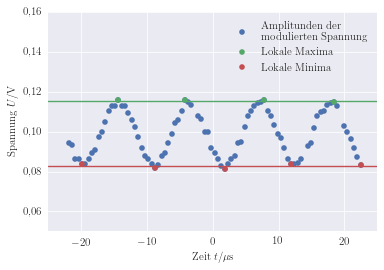

In [213]:
fig, ax = plt.subplots()

t = np.linspace(-2.5e-05,2.5e-05,100)
ax.set_xlim(-2.5e-05,2.5e-05)
ax.set_ylim(0.05,0.16)
#axis_scale(1e06,axis="x") # seconds -> microseconds 
siunitx_ticklabels(ax=ax,scale_x=1e06,round_precision=(0,2))
ax.set_xlabel(axis_label("Zeit",sym="t",unit="\mu s"))
ax.set_ylabel(axis_label("Spannung",sym="U",unit="V"))
ax.plot(df_voltage_loc_max["Zeit/s"],df_voltage_loc_max["Spannung/V"],marker="o",linestyle="",
        label="Amplitunden der\n modulierten Spannung")
line_max = ax.plot(voltage_max[:,:1],voltage_max[:,1:],marker="o",linestyle="",label="Lokale Maxima")
line_min = ax.plot(voltage_min[:,:1],voltage_min[:,1:],marker="o",linestyle="",label="Lokale Minima")

ax.plot(t, [voltage_max_mean]*len(t),color=line_max[0].get_color())
ax.plot(t, [voltage_min_mean]*len(t),color=line_min[0].get_color())


ax.legend(loc="upper right")
#ax.plot(max_1[0],max_1[1],marker="o")


In [214]:
fig.tight_layout()
fig.savefig(graphic("Amplituden_Modulierte_Spannung_mit_Traeger_Modulationsgrad.pdf"))

### Berechnung des Modulationsgrads aus dem Frequenzspektrum

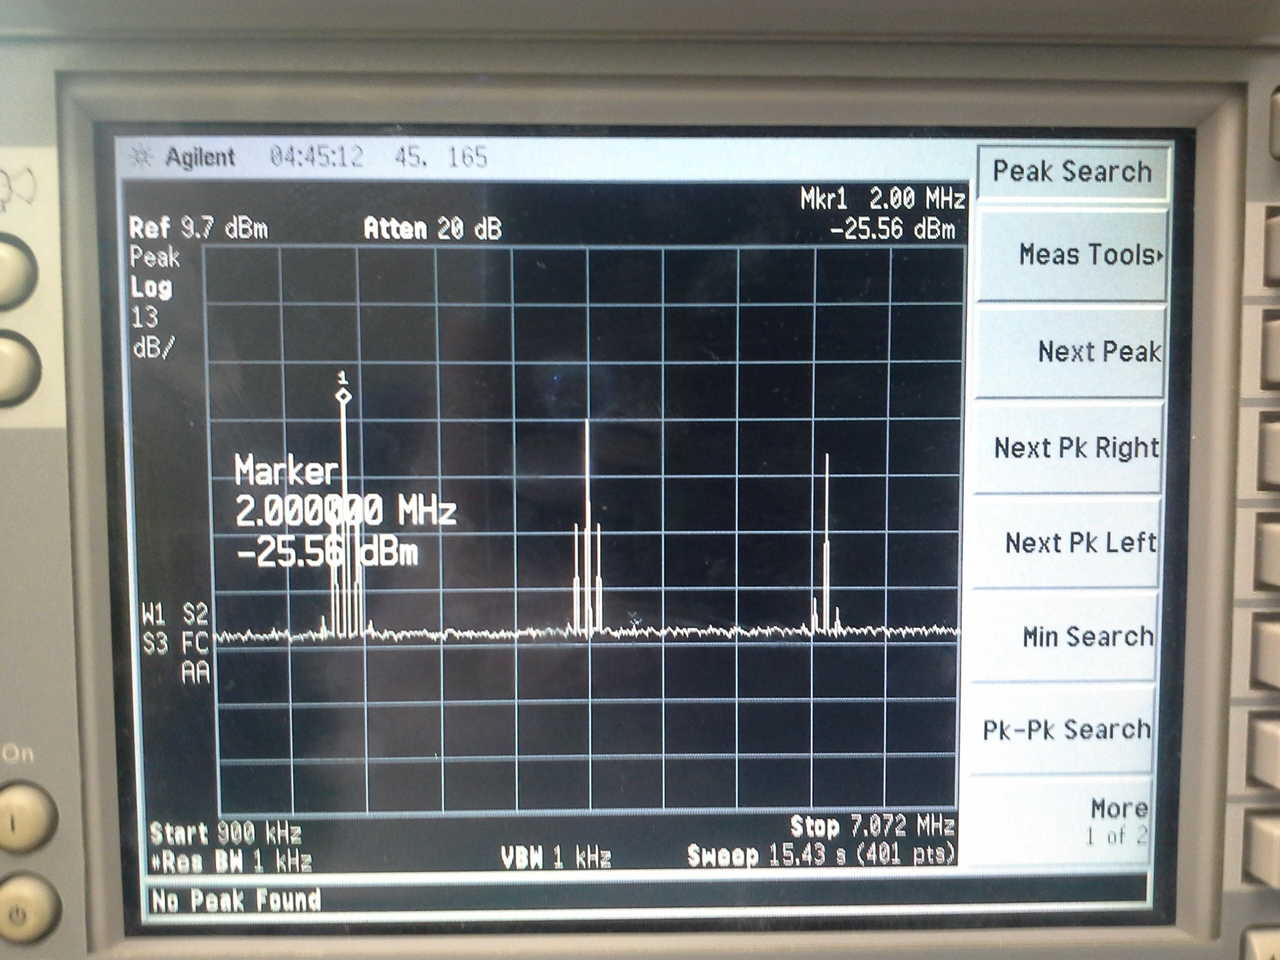

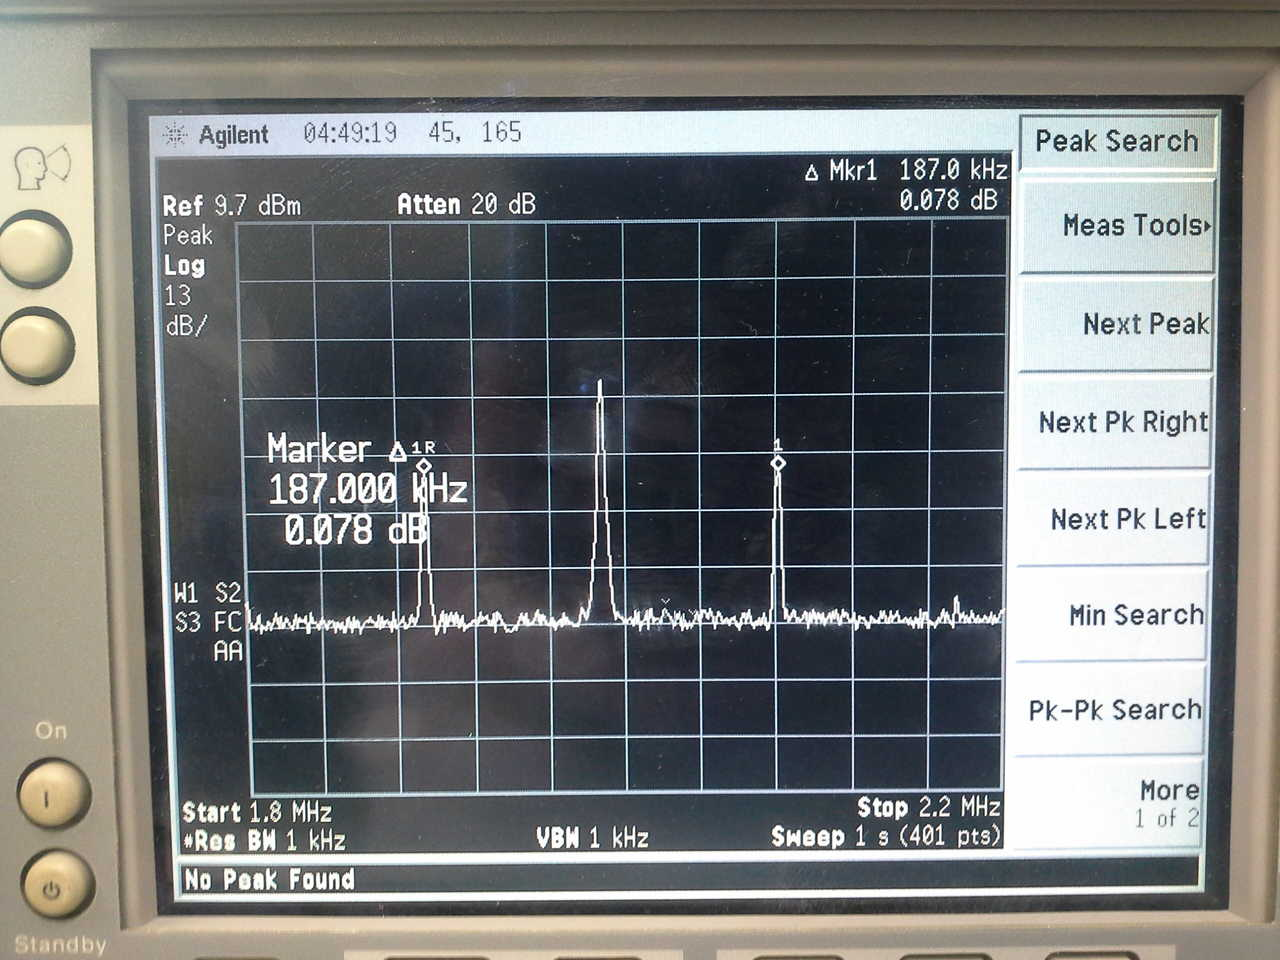

In [168]:
img1 = Image(graphic("Frequenzspektrum_c_AmpModuliertTräger_Oberwellen_0.jpg"),width=500)
img2 = Image(graphic("Frequenzspektrum_c_AmpModuliertTräger.jpg"),width=500)
display(img1,img2)

Das die Verstärkung des Hauptmaximums liegt bei -25.56dBm pro Einheit 
nimmt diese um 13dBm ab und nach Abmessung der Pixel liegen die "Trägerfrequenzen" 
ca. 21dBm unter dem Maximum. Die Leistung in mW ergibt sich nach $P_{mW} = 10^{(P_{dBm}/10)}$
und die Amplitude der Spannung ist proportional zu  $\sqrt{P_{mW}}$. Der Modulationsgrad ergibt sich 
aus $U_{MT} = \frac{m}{2}U_T$.

In [169]:
def dBm2milliWatt(P_dBm):
    return 10**(P_dBm/10)

P_T_dBm = -25.56
P_TM_dBm = P_T_dBm - 21 
P_T = dBm2milliWatt(P_T_dBm)
P_TM = dBm2milliWatt(P_TM_dBm)
U_T = np.sqrt(P_T)
U_TM = np.sqrt(P_TM)
m = U_TM/U_T * 2


print("Leistung(Träger):",P_T_dBm,"dBm")
print("Leistung(Modulation):",P_TM_dBm,"dBm")
print("Leistung(Träger):",P_T,"mW")
print("Leistung(Modulation):",P_TM,"mW")
print("Spannung(Träger):",U_T,"V")
print("Spannung(Modulation):",U_TM,"V")
print("Modulationsgrad:", m)

Leistung(Träger): -25.56 dBm
Leistung(Modulation): -46.56 dBm
Leistung(Träger): 0.0027797132677592883 mW
Leistung(Modulation): 2.2080047330188968e-05 mW
Spannung(Träger): 0.0527229861423 V
Spannung(Modulation): 0.00469894108605 V
Modulationsgrad: 0.178250187627


## Aufgabe d)
### Frequenzmoduliert

In [170]:
df_freq_mod = pd.read_csv(path_data+"Messung_d1.csv",skiprows=(0,1),names=("Zeit/s","Spannung/V","Spannung(Modulation)/V"))
df_freq_mod.fillna(0,inplace=True)

In [171]:
df_freq_mod.head(1)

,Zeit/s,Spannung/V,Spannung(Modulation)/V
0,-0.000028,0,0


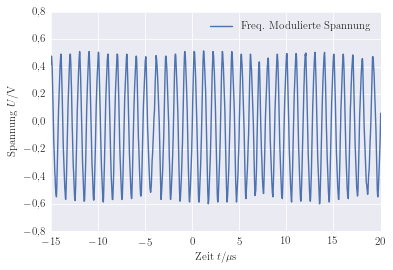

In [211]:
fig, ax = plt.subplots()

ax.set_xlim(-1.5e-05,2e-05)
ax.set_ylim(-0.8,0.8)
#axis_scale(1e06,axis="x")
siunitx_ticklabels(ax=ax,scale_x=1e06,round_precision=(0,1))
ax.set_xlabel(axis_label("Zeit",sym="t",unit="\mu s"))
ax.set_ylabel(axis_label("Spannung",sym="U",unit="V"))
ax.plot(df_freq_mod["Zeit/s"],df_freq_mod["Spannung/V"],label="Freq. Modulierte Spannung")
ax.legend(loc="upper right")


In [212]:
fig.tight_layout()
fig.savefig(graphic("Frequenz_Modulierte_Spannung.pdf"))

### Berechnung des Frequenzhubs und des Modulationsgrades

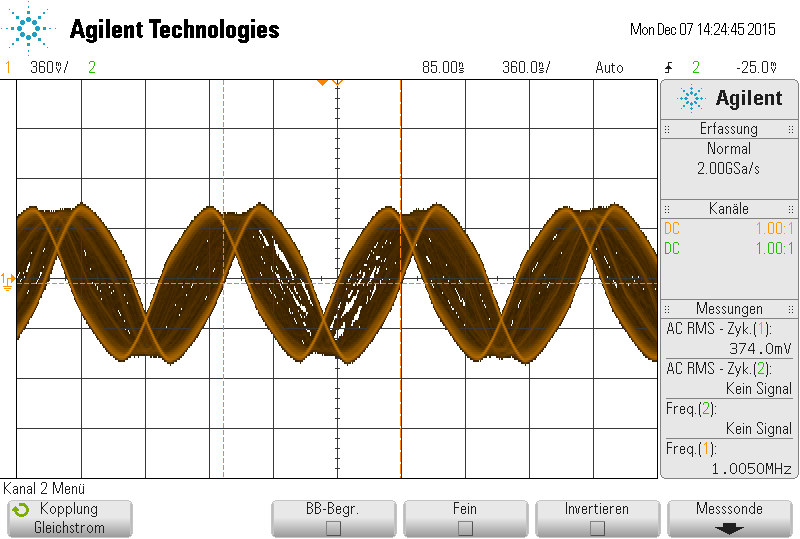

In [174]:
Image(graphic("Messung_d2.png"),width=500)

Von der y-Achse t=0 aus liegt die zweite Grenze der Kurven auf der folgenden t-Einteilung t=360ns.
Der Kehrwert dieser Zeitdifferenz ist der Frequenzhub $\Delta f$ aus dem sich über $\Delta f = mf_{T}$
der Modulationsgrad $m$ bestimmen lässt.

In [175]:
dt = 360e-09
df = 1/dt
m = df/1e06

print("Zeitdifferenz:",dt,"s")
print("Frequenzhub:",df,"Hz")
print("Modulationsgrad:", m)


Zeitdifferenz: 3.6e-07 s
Frequenzhub: 2777777.777777778 Hz
Modulationsgrad: 2.777777777777778


## Aufgabe e)
### Phasenempfindlicher Gleichrichter

In [176]:
df_freq_dcvoltage = pd.read_csv(path_data+"PhasenempfindlicherGleichrichter_e.csv")
df_freq_dcvoltage.fillna(0,inplace=True)

In [177]:
df_freq_dcvoltage.head(1)

,Frequenz/MHz,Spannung/mV
0,0.252,70.8


In [178]:
def freq_2_phase_shift(f):
    dt = 250e-9
    return 2*const.pi * f * dt

In [179]:
# Fehler der Phase
phase_err = freq_2_phase_shift(1e03)
print("Fehler der Phase:",phase_err)

Fehler der Phase: 0.0015707963267948964


In [180]:
df_freq_dcvoltage["Phasenverschiebung"] = freq_2_phase_shift(df_freq_dcvoltage["Frequenz/MHz"]*1e06)

In [181]:
df_freq_dcvoltage.head(1)

,Frequenz/MHz,Spannung/mV,Phasenverschiebung
0,0.252,70.8,0.395841


In [182]:
phase_err = np.array([0.002]*len(df_freq_dcvoltage["Phasenverschiebung"]))
voltage_err = np.array([1]*len(df_freq_dcvoltage["Spannung/mV"]))

In [260]:
# Fit der Messwerte mit dem cos(phi)
def cos(phi,a,b):
    return a * np.cos(phi + b)

popt, pcov = sp.optimize.curve_fit(cos, df_freq_dcvoltage["Phasenverschiebung"],df_freq_dcvoltage["Spannung/mV"],
                                   p0=(90,0.2))

param_a, param_b = fit_errors(popt,pcov)

print("Amplitude:", param_a)
print("Phase:", param_b, param_b/const.pi * 180)
#print("Y-Verschiebung:", param_c)
print(pcov)

Amplitude: 89.1+/-1.6
Phase: 0.048+/-0.018 2.8+/-1.0
[[  2.45711017e+00  -2.34080588e-05]
 [ -2.34080588e-05   3.10101510e-04]]


In [265]:
cos_err = param_a* unp.cos(P+  param_b)
cos_err[:10]

array([80.42342172625452+/-1.567698799757827,
       80.19629444798736+/-1.5677033198447519,
       79.96637896693609+/-1.5677078823870332,
       79.73368327662448+/-1.567712486749801,
       79.49821546723645+/-1.5677171322923715,
       79.25998372533479+/-1.5677218183683368,
       79.0189963335766+/-1.5677265443256543,
       78.77526167042524+/-1.5677313095067382,
       78.52878820985913+/-1.5677361132485514,
       78.27958452107706+/-1.5677409548826973], dtype=object)

In [263]:
cos(P,*popt)[:10]

array([ 80.42342173,  80.19629445,  79.96637897,  79.73368328,
        79.49821547,  79.25998373,  79.01899633,  78.77526167,
        78.52878821,  78.27958452])

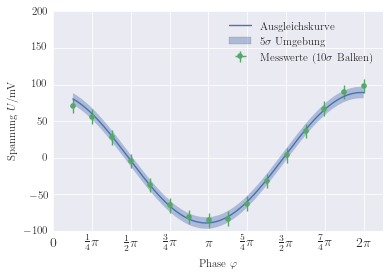

In [267]:
fig, ax = plt.subplots()
P = np.linspace(df_freq_dcvoltage["Phasenverschiebung"].min(),df_freq_dcvoltage["Phasenverschiebung"].max(),1000)
ax.set_xlim(0,2.125*const.pi)
ax.set_ylim(-100,200)
#axis_scale(1e06,axis="x")
#siunitx_ticklabels(ax=ax)
create_pi_labels(a=0, b=2.125, step=0.25, ax=ax, direction='x')
ax.set_xlabel(axis_label("Phase",sym=r"\varphi"))
ax.set_ylabel(axis_label("Spannung",sym="U",unit="mV"))

plt.plot(P,cos(P,*popt),label="Ausgleichskurve")
sigma = ax.fill_between(P,noms(cos_err)- 5*stds(cos_err),
                noms(cos_err)+ 5*stds(cos_err),
                edgecolor="",alpha=0.4)
ax.bar(0,0,width=0,color=sigma.get_facecolor()[0][:-1],edgecolor="",label=r"5$\sigma$ Umgebung",alpha=0.4)
#plt.plot(P,cos(P,noms(param_a)+stds(param_a),noms(param_b)+stds(param_b)))
#plt.plot(P,cos(P,noms(param_a)-stds(param_a),noms(param_b)-stds(param_b)))

x = np.array(df_freq_dcvoltage["Phasenverschiebung"])
y = np.array(df_freq_dcvoltage["Spannung/mV"])

ax.errorbar(x,y,yerr=10*voltage_err,xerr=10*phase_err, marker="o",linestyle="",label="Messwerte (10$\sigma$ Balken)")

ax.legend(loc="upper right")


In [245]:
fig.tight_layout()
fig.savefig(graphic("Phasenempfindlicher_Gleichrichter.pdf"))

## Aufgabe f)
### Amplituden-Demodulation mit Ringmodulator

In [186]:
df_amp_mod_ring_demod = pd.read_csv(path_data+"Messung_f.csv",skiprows=(0,1),names=("Zeit/s","Spannung/V","Spannung(Modulation)/V"))
df_amp_mod_ring_demod.fillna(0,inplace=True)

In [187]:
df_amp_mod_ring_demod.head(1)

,Zeit/s,Spannung/V,Spannung(Modulation)/V
0,-0.00005,0.007236,-0.209045


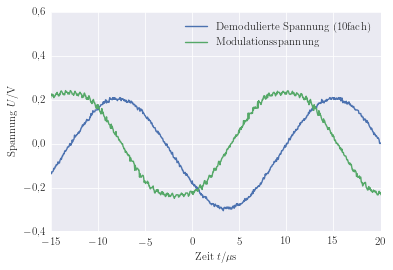

In [206]:
fig, ax = plt.subplots()

ax.set_xlim(-1.5e-05,2e-05)
ax.set_ylim(-0.4,0.6)
#axis_scale(1e06,axis="x")
siunitx_ticklabels(ax=ax,scale_x=1e06,round_precision=(0,1))
ax.set_xlabel(axis_label("Zeit",sym="t",unit="\mu s"))
ax.set_ylabel(axis_label("Spannung",sym="U",unit="V"))
ax.plot(df_amp_mod_ring_demod["Zeit/s"],10*df_amp_mod_ring_demod["Spannung/V"],label="Demodulierte Spannung (10fach)")
ax.plot(df_amp_mod_ring_demod["Zeit/s"],df_amp_mod_ring_demod["Spannung(Modulation)/V"],label="Modulationsspannung")
ax.legend(loc="upper right")


In [207]:
fig.tight_layout()
fig.savefig(graphic("Amplituden_Modulation_Ring_Demodulation.pdf"))

## Aufgabe g)
### Amplituden-Demodulation mit Diode

In [190]:
df_amp_mod_diode_demod_rectifier = pd.read_csv(path_data+"Messung_g1.csv",skiprows=(0,1),names=("Zeit/s","Spannung/V","Spannung(Modulation)/V"))
df_amp_mod_diode_demod_rectifier.fillna(0,inplace=True)
df_amp_mod_diode_demod_lowpass = pd.read_csv(path_data+"Messung_g2.csv",skiprows=(0,1),names=("Zeit/s","Spannung/V","Spannung(Modulation)/V"))
df_amp_mod_diode_demod_lowpass.fillna(0,inplace=True)

In [191]:
df_amp_mod_diode_demod_rectifier.head(1)

,Zeit/s,Spannung/V,Spannung(Modulation)/V
0,-0.000025,0,0


In [192]:
df_amp_mod_diode_demod_lowpass.head(1)

,Zeit/s,Spannung/V,Spannung(Modulation)/V
0,-0.000025,0.005264,-0.249246


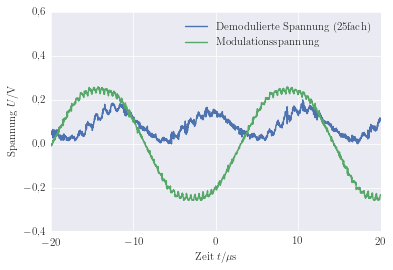

In [193]:
fig, ax = plt.subplots()

ax.set_xlim(-2e-05,2e-05)
ax.set_ylim(-0.4,0.6)
#axis_scale(1e06,axis="x")
siunitx_ticklabels(ax=ax,scale_x=1e06,round_precision=(0,1))
ax.set_xlabel(axis_label("Zeit",sym="t",unit="\mu s"))
ax.set_ylabel(axis_label("Spannung",sym="U",unit="V"))
ax.plot(df_amp_mod_diode_demod_lowpass["Zeit/s"],25*df_amp_mod_diode_demod_lowpass["Spannung/V"],label="Demodulierte Spannung (25fach)")
ax.plot(df_amp_mod_diode_demod_lowpass["Zeit/s"],df_amp_mod_diode_demod_lowpass["Spannung(Modulation)/V"],label="Modulationsspannung")
ax.legend(loc="upper right")


In [194]:
fig.savefig(graphic("Amplituden_Modulation_Diode_Demodulation_Tiefpass.pdf"))

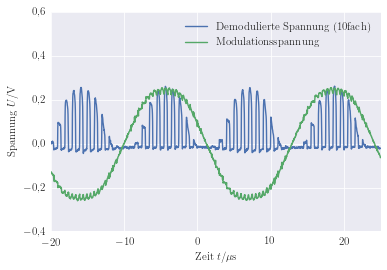

In [204]:
fig, ax = plt.subplots()

ax.set_xlim(-2.0e-05,2.5e-05)
ax.set_ylim(-0.4,0.6)
#axis_scale(1e06,axis="x")
siunitx_ticklabels(ax=ax,scale_x=1e06,round_precision=(0,1))
ax.set_xlabel(axis_label("Zeit",sym="t",unit="\mu s"))
ax.set_ylabel(axis_label("Spannung",sym="U",unit="V"))
ax.plot(df_amp_mod_diode_demod_rectifier["Zeit/s"],10*df_amp_mod_diode_demod_rectifier["Spannung/V"],label="Demodulierte Spannung (10fach)")
ax.plot(df_amp_mod_diode_demod_rectifier["Zeit/s"],df_amp_mod_diode_demod_rectifier["Spannung(Modulation)/V"],label="Modulationsspannung")
ax.legend(loc="upper right")


In [205]:
fig.tight_layout()
fig.savefig(graphic("Amplituden_Modulation_Diode_Demodulation_Gleichrichter.pdf"))

## Aufgabe h)
### Frequenz-Demodulation mit Ringdemodulator

In [197]:
df_freq_mod_ring_demod_ampmod = pd.read_csv(path_data+"Messung_h1.csv",skiprows=(0,1),names=("Zeit/s","Spannung/V","Spannung(Modulation)/V"))
df_freq_mod_ring_demod_ampmod.fillna(0,inplace=True)
df_freq_mod_ring_demod = pd.read_csv(path_data+"Messung_h2.csv",skiprows=(0,1),names=("Zeit/s","Spannung/V","Spannung(Modulation)/V"))
df_freq_mod_ring_demod.fillna(0,inplace=True)

In [198]:
df_freq_mod_ring_demod_ampmod.head(1)

,Zeit/s,Spannung/V,Spannung(Modulation)/V
0,-0.000025,0,0


In [199]:
df_freq_mod_ring_demod.head(1)

,Zeit/s,Spannung/V,Spannung(Modulation)/V
0,-0.00019,-0.001447,-1.755276


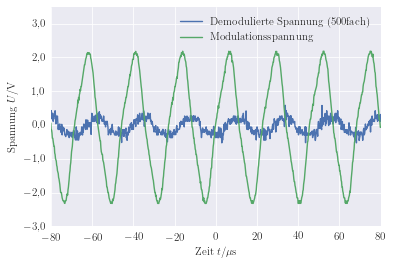

In [221]:
fig, ax = plt.subplots()

ax.set_xlim(-8e-05,8e-05)
ax.set_ylim(-3.0,3.5)
#axis_scale(1e06,axis="x")
siunitx_ticklabels(ax=ax,scale_x=1e06,round_precision=(0,1))
ax.set_xlabel(axis_label("Zeit",sym="t",unit="\mu s"))
ax.set_ylabel(axis_label("Spannung",sym="U",unit="V"))
ax.plot(df_freq_mod_ring_demod["Zeit/s"],500*df_freq_mod_ring_demod["Spannung/V"]+0.75,label="Demodulierte Spannung (500fach)")
ax.plot(df_freq_mod_ring_demod["Zeit/s"],df_freq_mod_ring_demod["Spannung(Modulation)/V"],label="Modulationsspannung ")
ax.legend(loc="upper right")


In [222]:
fig.tight_layout()
fig.savefig(graphic("Frequenz_Moduliert_Demodulation.pdf"))

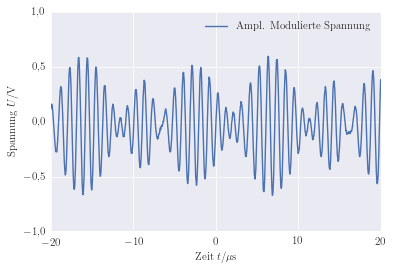

In [202]:
fig, ax = plt.subplots()

ax.set_xlim(-2e-05,2e-05)
ax.set_ylim(-1,1)
#axis_scale(1e06,axis="x")
siunitx_ticklabels(ax=ax,scale_x=1e06,round_precision=(0,1))
ax.set_xlabel(axis_label("Zeit",sym="t",unit="\mu s"))
ax.set_ylabel(axis_label("Spannung",sym="U",unit="V"))
ax.plot(df_freq_mod_ring_demod_ampmod["Zeit/s"],df_freq_mod_ring_demod_ampmod["Spannung/V"],label="Ampl. Modulierte Spannung")
#ax.plot(df_freq_mod_ring_demod_ampmod["Zeit/s"],1000*df_freq_mod_ring_demod_ampmod["Spannung(Modulation)/V"],label="Modulationsspannung ")
ax.legend(loc="upper right")


In [203]:
fig.tight_layout()
fig.savefig(graphic("Frequenz_Moduliert_Demodulation_Amplitude.pdf"))